## Exploring Sakila using SQLite, pythons pandas library and jupyter notebook.

Database SOURCE: <br>
https://www.kaggle.com/datasets/atanaskanev/sqlite-sakila-sample-database <br>
The Sakila sample database is a fictitious database designed to represent a DVD rental store. The database tables include film, film_category, actor, customer, rental, payment and inventory among others.
The Sakila sample database is intended to provide a standard schema that can be used for examples in books, tutorials, articles, samples, and so forth.


Detailed information about the database can be found on the MySQL website: https://dev.mysql.com/doc/sakila/en/
License: BSD
Copyright DB Software Laboratory
http://www.etl-tools.com

The SQL implementation used for this notebook is SQLite3

This is a list of hypothetical marketing-related questions about the DVD rental store under study. In the next section, I provide an answer for each of these questions by running queries against the Sakila database.

1. Specify the date range of Sales/Rental Data Collection. <br>
2. Display total sales per store, location of stores and number of customers. Find total sales and customers number for all stores.<br>
3. Display the sales and transactions per month.<br>

4.  Display the email and location of the store managers.<br>

5.  Top ten customers who rented the most films.<br>

6. How many rented movies were not returned, returned on time or late?<br>
7.  Display movies that are currently out on rent. Show customers and their email addresses.<br>
8.  Find the average rental duration.<br>
9.  Overdue unreturned movies. <br>
10. The top 15 most popular movies among store customers<br>
11. Which actor is the most popular among store customers, given rental history? What are the top 5 rented movies of the most   popular actor?<br>
12. Which actors starred the most in the store inventory films?

# Preparation / Connecting to the database

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library

## Connecting to the database

In [3]:
pd.options.display.max_rows = 50 # maximum number of rows to display
db_connect = sqlite3.connect('sqlite-sakila.db')


In [8]:
#We can now query the database directly in this environment using pandas' read_sql method.
#Display the information about the database schema by accessing the sqlite_master.
tables= pd.read_sql("""
SELECT *        
FROM sqlite_master
WHERE type= 'table';
""",db_connect)
tables

,type,name,tbl_name,rootpage,sql
0,table,actor,actor,2,CREATE TABLE actor (\n actor_id numeric NOT N...
1,table,country,country,5,CREATE TABLE country (\n country_id SMALLINT ...
2,table,city,city,7,"CREATE TABLE city (\n city_id int NOT NULL,\n..."
3,table,address,address,10,CREATE TABLE address (\n address_id int NOT N...
4,table,language,language,13,CREATE TABLE language (\n language_id SMALLIN...
5,table,category,category,15,CREATE TABLE category (\n category_id SMALLIN...
6,table,customer,customer,19,CREATE TABLE customer (\n customer_id INT NOT...
7,table,film,film,24,"CREATE TABLE film (\n film_id int NOT NULL,\n..."
8,table,film_actor,film_actor,28,CREATE TABLE film_actor (\n actor_id INT NOT ...
9,table,film_category,film_category,33,CREATE TABLE film_category (\n film_id INT NO...


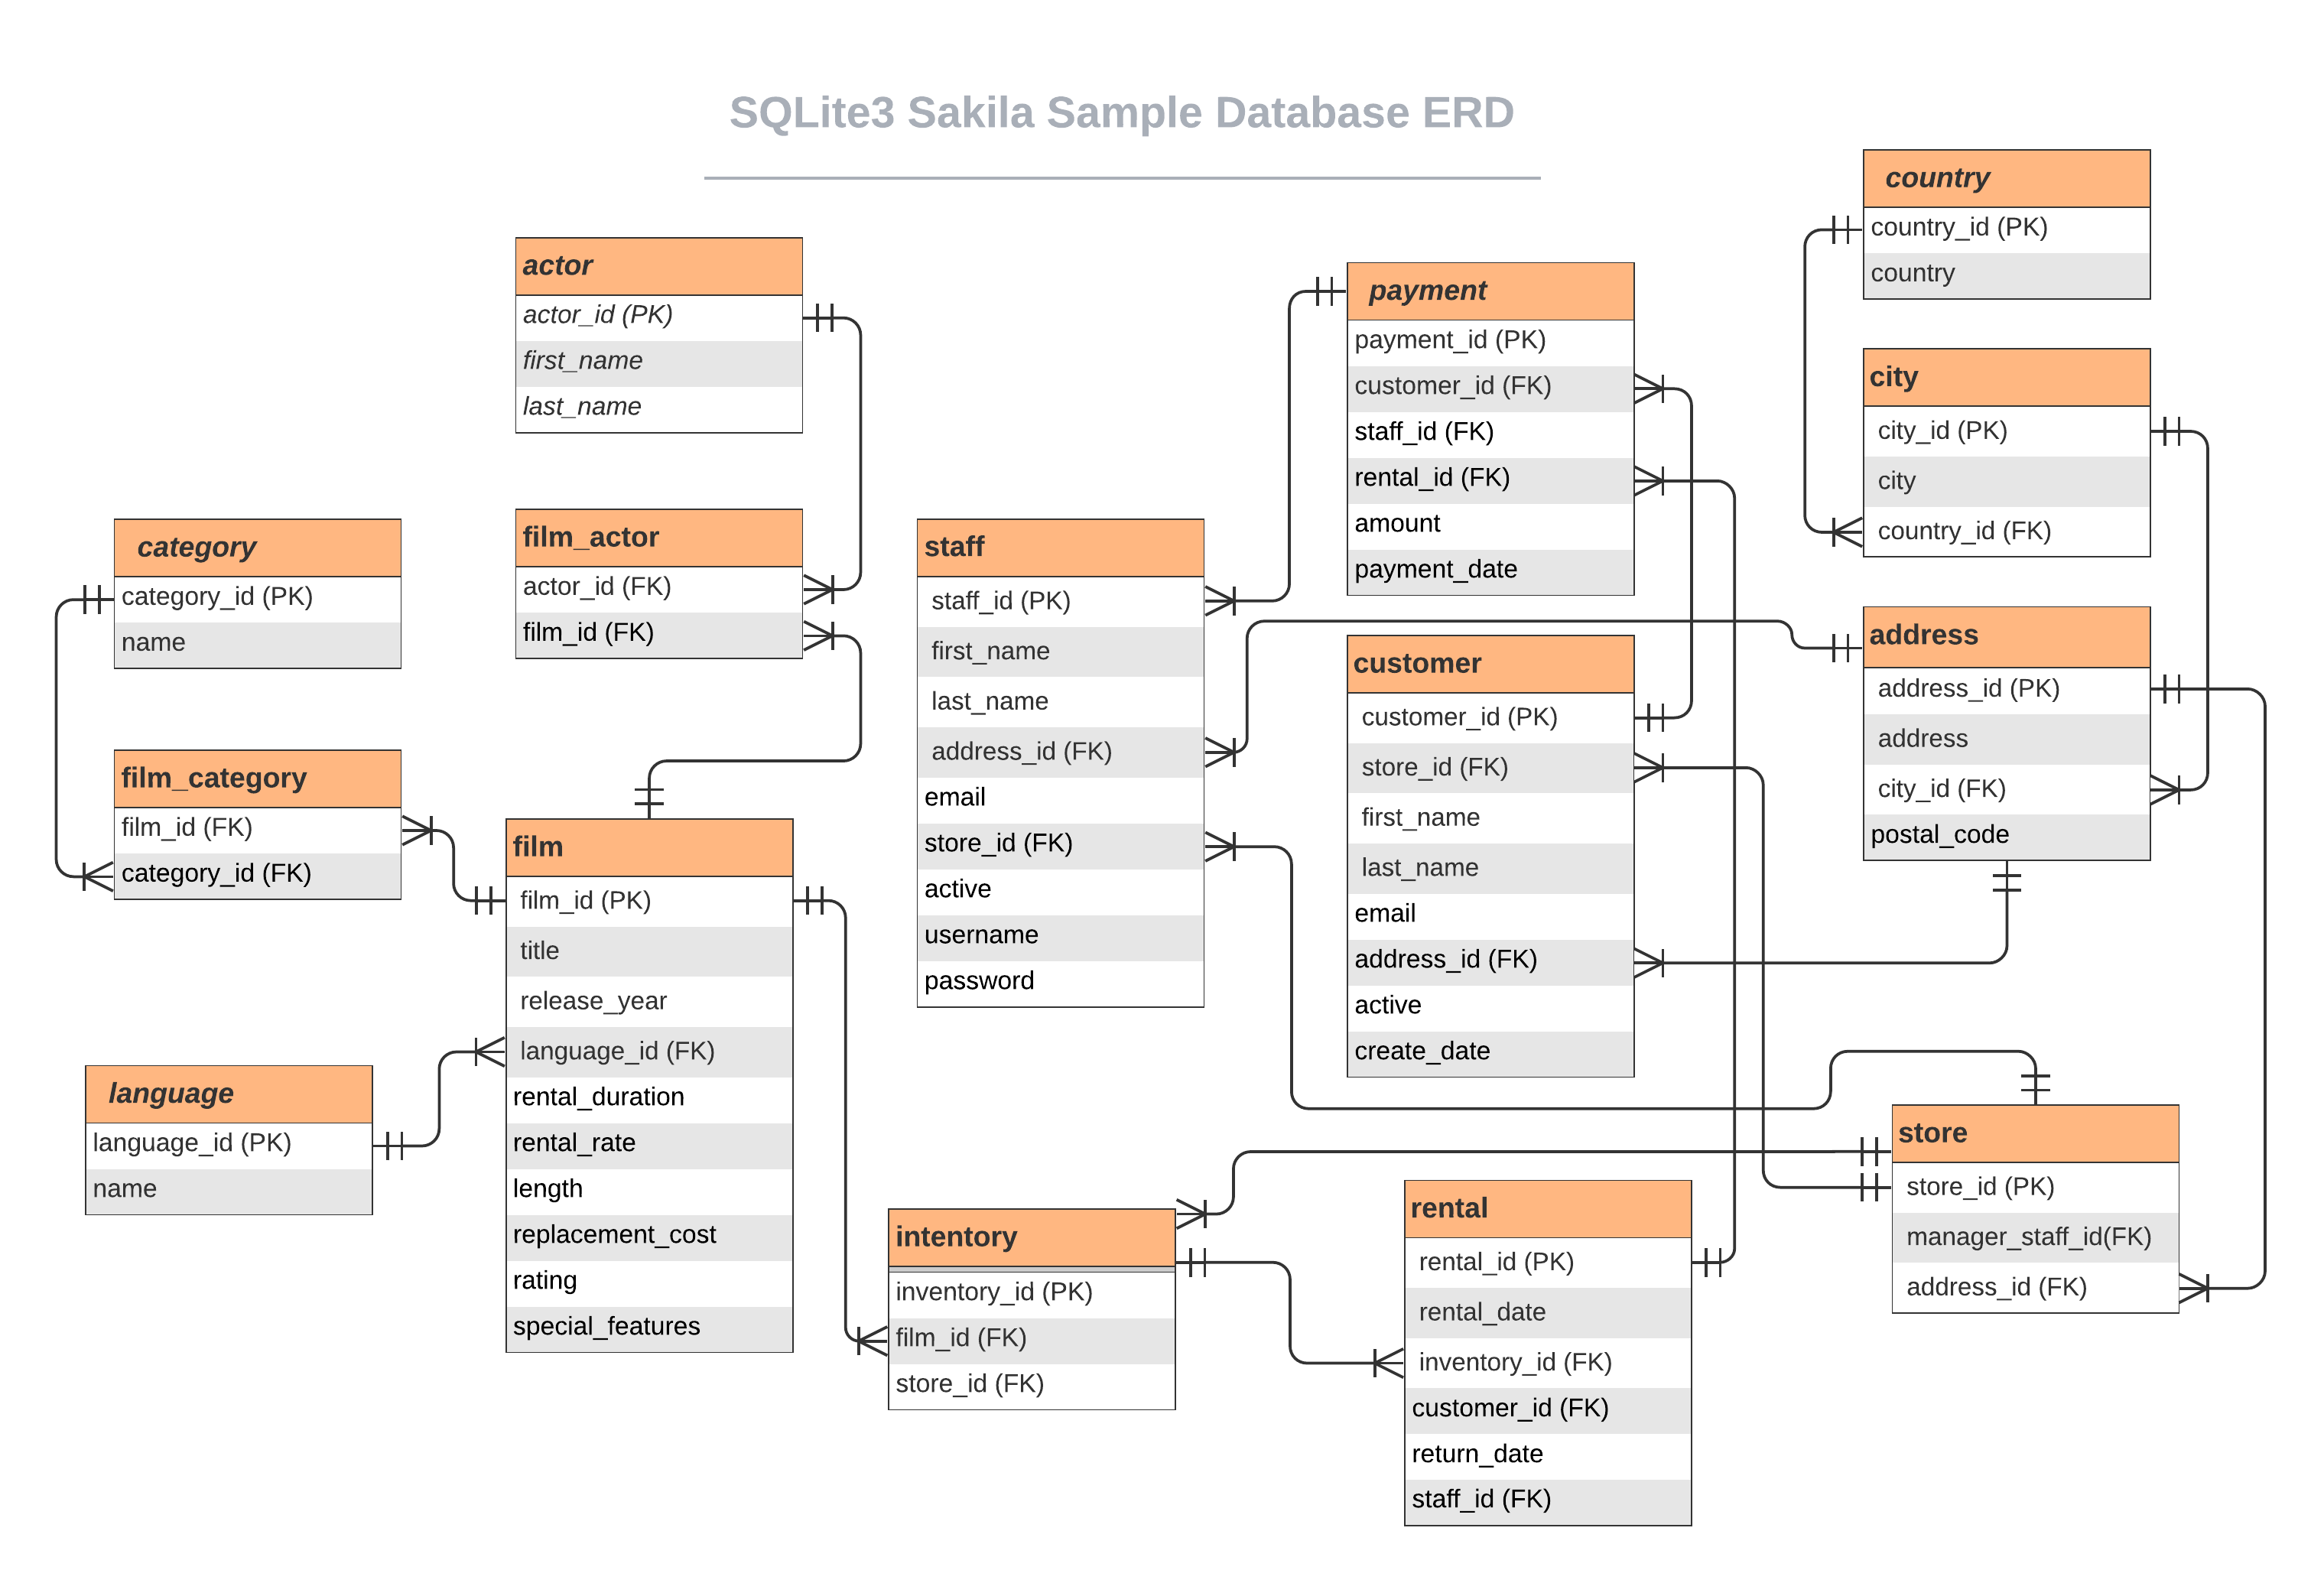

In [29]:
#Display the image of the database schema
img = Image.open('SQLite3 Sakila Sample Database ERD.png')
img

In [81]:
# This is a fictitious sample database. Let's assume that DVD rental store performance period is between minimum and 
#maximum rental_dates
rental_period= pd.read_sql("""
SELECT MIN(date(rental_date,)) as begin_date, MAX(Date(rental_date)) as end_date
FROM rental;
""",db_connect)
rental_period


,begin_date,end_date
0,2005-05-24,2006-02-14


In [153]:
#Explore when was the first and last payment made.
payments_period= pd.read_sql("""
SELECT MIN(date(payment_date)) as begin_date, MAX(Date(payment_date)) as end_date
FROM payment;
""",db_connect)
payments_period

,begin_date,end_date
0,2005-05-24,2006-02-14


We can assume that the sales data was collected between 24 May 2005 and 14 February 2006. Approximately 9 months in total.

### It is time to explore how many stores are there and store performance. Display the number of customers and sales per store?

In [282]:
#Dispaly location, sales and customer number per store. Use Common Table Expression
#ADD total sales/customers row using Union operator.

stores=pd.read_sql("""
WITH 
location AS(
  SELECT city,country, address_id
  FROM city ci
  JOIN country co
  USING(country_id)
  JOIN address ad
  USING(city_id))

SELECT s.store_id,l.city, l.country, SUM(amount) AS total_sales, COUNT(DISTINCT(c.customer_id)) AS customer_count
FROM location l
JOIN store s
ON l.address_id=s.address_id
JOIN customer c
ON s.store_id=c.store_id
JOIN payment p
ON c.customer_id=p.customer_id
GROUP BY s.store_id
UNION 
SELECT (store_id || '_Total'),REPLACE(city,'Sasebo',''), REPLACE(country,'Japan','') ,SUM(amount), COUNT(DISTINCT(customer_id))
from payment p
JOIN customer USING(customer_id)
JOIN store USING(store_id)
JOIN location USING(address_id);
""",db_connect)
stores

,store_id,city,country,total_sales,customer_count
0,1,Lethbridge,Canada,37001.52,326
1,2,Woodridge,Australia,30414.99,273
2,1_Total,,,67416.51,599


As we can see, only two stores are in the Sakila database. The store located in Canada is more popular among customers and has a higher number of sales than in Australia. Is this table correct? 

In [318]:
#Try another table combination to get the result of sales allocation
#Surpisingly the allocation of sales among stores is different if we access store_id and location from the staff table.
store_id_staff=pd.read_sql("""
SELECT s.store_id, SUM(amount) AS sales
FROM payment p
JOIN staff st
ON p.staff_id=st.staff_id
JOIN store s
ON st.store_id=s.store_id
GROUP BY s.store_id;
""",db_connect)
store_id_staff

,store_id,sales
0,1,33489.47
1,2,33927.04


Find the difference in sales allocation results. Payment_id and amount columns for some reason are allocated
differently between stores in staff and customer tables.<br>
Let us compare staff table store_id and customer tables store_id.<br>
Take the payment_id and amount from the payment table and match them with the corresponding store_id from the staff table 
and store_id from the customer.

In [285]:
sales_comparison=pd.read_sql("""
SELECT payment_id,st.store_id as staff_storeID, c.store_id as customer_storeID, amount AS sales
FROM staff st
JOIN payment p
ON st.staff_id=p.staff_id
JOIN customer c
ON p.customer_id=c.customer_id
WHERE staff_storeID<>customer_storeID;
""",db_connect)
sales_comparison

,payment_id,staff_storeID,customer_storeID,amount
0,4,2,1,0.99
1,5,2,1,9.99
2,8,2,1,0.99
3,10,2,1,5.99
4,15,2,1,2.99
...,...,...,...,...
7992,16037,1,2,2.99
7993,16040,1,2,6.99
7994,16044,1,2,1.99
7995,16045,1,2,4.99


There are 7997 where for the same payment_ID customer table store-id does not match staff table store_id.<br>
Let's take a look at the customer's addresses.

In [257]:
customer_country=pd.read_sql("""
WITH
location AS(
  SELECT city,country, address_id
  FROM city ci
  JOIN country co
  USING(country_id)
  JOIN address ad
  USING(city_id))

SELECT count(payment_id) as payment_count,count(p.customer_id) as customer_count, country,count(DISTINCT(store_id)) as distinct_store_count
FROM customer c
JOIN location
USING(address_id)
JOIN payment p
ON p.customer_id=c.customer_id
JOIN store
USING(store_id)
GROUP BY country
ORDER BY customer_count DESC;
""",db_connect)
customer_country

,payment_count,customer_count,country,distinct_store_count
0,1573,1573,India,2
1,1427,1427,China,2
2,968,968,United States,2
3,826,826,Japan,2
4,796,796,Mexico,2
...,...,...,...,...
103,22,22,Madagascar,1
104,22,22,French Guiana,1
105,20,20,American Samoa,1
106,18,18,Tonga,1


Both stores have clients from 107 different countries. Most customers are from India and China, which is unrealistic information due to the fact that stores are located in Canada and Australia. However, this is a fictitious sample database, so the data might not be very realistic. Probably staff store_id is more reliable for finding sales allocation among stores.

In [277]:
staff_table=pd.read_sql("""
WITH
location AS(
  SELECT city,country, address_id
  FROM city ci
  JOIN country co
  USING(country_id)
  JOIN address ad
  USING(city_id))

  
SELECT st.staff_id, s.store_id, country, SUM(amount) as payment
FROM staff st
JOIN location l
ON st.address_id=l.address_id
JOIN store s
ON st.store_id=s.store_id
JOIN payment p
ON st.staff_id=p.staff_id
GROUP BY s.store_id

""",db_connect)
staff_table

,staff_id,store_id,country,payment
0,1,1,Canada,33489.47
1,2,2,Australia,33927.04


### Display sales and transactions per month.

In [204]:
distinct2_rental_date=pd.read_sql("""
SELECT STRFTIME('%Y-%m', rental_date) as date, COUNT(*)as transaction_count, SUM(amount) as total_sales
FROM rental 
JOIN payment USING (rental_id)
GROUP BY date
ORDER BY date;
""",db_connect)
distinct2_rental_date

,date,transaction_count,total_sales
0,2005-05,1156,4823.44
1,2005-06,2311,9629.89
2,2005-07,6709,28368.91
3,2005-08,5686,24070.14
4,2006-02,182,514.18


An interesting finding is that there is a gap of 6 months between Aug-2005 and Feb-2006.

### Display full name, the email and location of the store managers.

In [283]:
manager=pd.read_sql("""
WITH
location AS(
  SELECT city,country, address_id
  FROM city ci
  JOIN country co
  USING(country_id)
  JOIN address ad
  USING(city_id))

SELECT store_id,first_name||' '||last_name AS store_manager , email, country, city
FROM store
JOIN staff
USING(store_id)
JOIN location
USING(address_id)
WHERE staff_id=manager_staff_id;
""",db_connect)
manager

,store_id,store_manager,email,country,city
0,1,Mike Hillyer,Mike.Hillyer@sakilastaff.com,Canada,Lethbridge
1,2,Jon Stephens,Jon.Stephens@sakilastaff.com,Australia,Woodridge


### The top ten customers who rented the most films.

In [135]:
#Total rent count
total_rent=pd.read_sql("""
SELECT COUNT(*) AS total_rent_count
FROM rental;
""",db_connect)
total_rent

,total_rent_count
0,16044


In [281]:
rent_count= pd.read_sql("""
WITH
location AS(
  SELECT city,country, address_id
  FROM city ci
  JOIN country co
  USING(country_id)
  JOIN address ad
  USING(city_id))
  
SELECT c.customer_id, c.first_name||" "||c.last_name as Customer, count(*) AS rental_count, country       
FROM customer AS c
JOIN rental AS r
ON c.customer_id=r.customer_id
JOIN location l
USING(address_id)
GROUP BY c.customer_id
ORDER BY rental_count DESC
LIMIT 10;
""",db_connect)
rent_count

,customer_id,Customer,rental_count,country
0,148,ELEANOR HUNT,46,Runion
1,526,KARL SEAL,45,United States
2,144,CLARA SHAW,42,Belarus
3,236,MARCIA DEAN,42,Philippines
4,75,TAMMY SANDERS,41,Taiwan
5,197,SUE PETERS,40,China
6,469,WESLEY BULL,40,Spain
7,137,RHONDA KENNEDY,39,Netherlands
8,178,MARION SNYDER,39,Brazil
9,468,TIM CARY,39,India


### How many rented movies were not returned, returned on timeor late?

In the rental table when a rented film has not been returned yet, this is represented with a NULL value in the return_date 
column.

In [316]:
rent_category = pd.read_sql_query("""
WITH days_table as (
SELECT strftime('%d-%m-%Y', return_date)-strftime('%d-%m-%Y', rental_date) as days_count, rental_duration, return_date
FROM film f
JOIN inventory USING(film_id)
JOIN rental USING(inventory_id))

SELECT COUNT(*) as film_count,
      (CASE 
          WHEN return_date IS NULL then 'not returned'
          WHEN days_count>rental_duration then 'overdue_rent'
          WHEN days_count<=rental_duration then 'returned_on_time'
          ELSE 'unknown'
          END) as status
FROM days_table
group by status
order by film_count
""", db_connect)
rent_category

,film_count,status
0,183,not returned
1,5242,overdue_rent
2,10619,returned_on_time


### Display movies that are currently out on rent. Show customers and their email addresses.

In [317]:
#Count Total unreturned movies.
unreturned_count=pd.read_sql("""
SELECT COUNT(*) AS films_on_rent
FROM rental
WHERE return_date IS NULL;
""",db_connect)
unreturned_count

,films_on_rent
0,183


In [297]:
# What movies are currently out on rent. Display the customers and their email addresses.
rented_movies= pd.read_sql("""
SELECT c.customer_id, c.first_name||" "||c.last_name AS Customer,  email, title AS movie_title, rental_duration,rental_date
FROM customer AS c
JOIN rental AS r
ON c.customer_id=r.customer_id
JOIN inventory i
ON r.inventory_id=i.inventory_id
JOIN film f
ON i.film_id=f.film_id
WHERE r.return_date IS NULL
GROUP BY c.customer_id
ORDER BY rental_date
LIMIT ;
""",db_connect)
rented_movies


,customer_id,Customer,email,movie_title,rental_duration,rental_date
0,554,DWAYNE OLVERA,DWAYNE.OLVERA@sakilacustomer.org,ACADEMY DINOSAUR,6,2005-08-21 00:30:32.000
1,5,ELIZABETH BROWN,ELIZABETH.BROWN@sakilacustomer.org,GABLES METROPOLIS,3,2006-02-14 15:16:03.000
2,9,MARGARET MOORE,MARGARET.MOORE@sakilacustomer.org,DEEP CRUSADE,6,2006-02-14 15:16:03.000
3,11,LISA ANDERSON,LISA.ANDERSON@sakilacustomer.org,BULL SHAWSHANK,6,2006-02-14 15:16:03.000
4,14,BETTY WHITE,BETTY.WHITE@sakilacustomer.org,GROUNDHOG UNCUT,6,2006-02-14 15:16:03.000
...,...,...,...,...,...,...
154,587,SERGIO STANFIELD,SERGIO.STANFIELD@sakilacustomer.org,CAMELOT VACATION,3,2006-02-14 15:16:03.000
155,590,SETH HANNON,SETH.HANNON@sakilacustomer.org,AFRICAN EGG,6,2006-02-14 15:16:03.000
156,592,TERRANCE ROUSH,TERRANCE.ROUSH@sakilacustomer.org,KICK SAVANNAH,3,2006-02-14 15:16:03.000
157,596,ENRIQUE FORSYTHE,ENRIQUE.FORSYTHE@sakilacustomer.org,GUNFIGHT MOON,5,2006-02-14 15:16:03.000


### The average rental duration.

In [148]:
#What is the average rental duration?
avg_renttime=pd.read_sql("""
SELECT AVG(JULIANDAY(return_date)-JULIANDAY( rental_date)) AS avg_rental_time
FROM rental;
""",db_connect)
avg_renttime

,avg_rental_time
0,5.02533


The average rental duration is approximately 5 days.

### Overdue unreturned movies.

In [319]:
#OVERDUE unreturned movies, assuming that today is 14 feb 2006 (The date of the last rent)
overdue_rent= pd.read_sql("""
SELECT c.customer_id, c.first_name||" "||c.last_name AS Customer,  title AS movie_title, rental_duration,
       DATE(rental_date) as rental_date, 
       return_date,
       strftime('%Y-%m-%d',JULIANDAY(rental_date)+JULIANDAY(rental_duration)) AS return_date1,
       ROUND(JULIANDAY('2006-02-15')-(JULIANDAY(rental_date)+JULIANDAY(rental_duration))) AS overdue_days
FROM customer AS c
JOIN rental AS r
ON c.customer_id=r.customer_id
JOIN inventory i
ON r.inventory_id=i.inventory_id
JOIN film f
ON i.film_id=f.film_id
WHERE r.return_date IS NULL AND
ROUND(JULIANDAY('2006-02-15')-(JULIANDAY(rental_date)+JULIANDAY(rental_duration)))>rental_duration
GROUP BY c.customer_id
ORDER BY rental_date
LIMIT 10;
""",db_connect)
overdue_rent


,customer_id,Customer,movie_title,rental_duration,rental_date,return_date,return_date1,overdue_days
0,554,DWAYNE OLVERA,ACADEMY DINOSAUR,6,2005-08-21,None,2005-08-27,172.0


In [286]:
#To test our output:
distinct_rental_date=pd.read_sql("""
SELECT DISTINCT(DATE(rental_date)) AS rental_date, return_date
FROM rental
WHERE return_date IS NULL
""",db_connect)
distinct_rental_date

,rental_date,return_date
0,2006-02-14,None
1,2005-08-21,None


There are only two dates where the return date is Null. 

In [305]:
df=pd.read_sql_query("""
SELECT strftime('%d-%m-%Y', return_date)-strftime('%d-%m-%Y', rental_date) AS days_count, rental_duration
FROM film f
JOIN inventory USING(film_id)
JOIN rental USING(inventory_id)

""", db_connect)
df

,days_count,rental_duration
0,2.0,7
1,4.0,7
2,-23.0,7
3,-21.0,6
4,-22.0,5
...,...,...
16039,2.0,5
16040,4.0,6
16041,2.0,4
16042,8.0,4


### The top 15 most popular movies among the store customers.

In [139]:
film_rank= pd.read_sql("""
SELECT f.title, COUNT(r.inventory_id)AS rent_count
FROM film AS f
JOIN inventory AS i
ON f.film_id = i.film_id
JOIN rental AS r
ON i.inventory_id=r.inventory_id
GROUP BY f.title
ORDER BY COUNT(r.inventory_id) DESC
LIMIT 15;
""",db_connect)
film_rank

,title,rent_count
0,BUCKET BROTHERHOOD,34
1,ROCKETEER MOTHER,33
2,SCALAWAG DUCK,32
3,RIDGEMONT SUBMARINE,32
4,JUGGLER HARDLY,32
5,GRIT CLOCKWORK,32
6,FORWARD TEMPLE,32
7,ZORRO ARK,31
8,WIFE TURN,31
9,TIMBERLAND SKY,31


### Which actor is the most popular among the store customers?

Before going into the question, it is important to check if there are any rows in the actor's table with the same first_name and last_name but different actor_id.

In [292]:
#actor table self join
actor_id_dublicate=pd.read_sql("""
SELECT A.actor_id, A.first_name, A.last_name
FROM actor A, actor B
WHERE A.first_name=B.first_name AND A.last_name=B.last_name AND A.actor_id<>B.actor_id
""",db_connect)
actor_id_dublicate

,actor_id,first_name,last_name
0,101,SUSAN,DAVIS
1,110,SUSAN,DAVIS


It seems that actress Susan Davis appears two times with different actor_id's.<br>
In the film industry two people will not likely use the same name and last name.<br>
To prevent duplication of results, I will group results by actor's full_name.

In [293]:
#Which actor is the most popular among store customers given rental history.
actor_rented=pd.read_sql("""
WITH
actor_info AS(
  SELECT first_name, last_name, fa.actor_id, film_id
  FROM actor a
  JOIN film_actor fa
  USING(actor_id)
)

SELECT ai.first_name ||' '|| ai.last_name as full_name, COUNT(rental_id) AS rents_count
FROM actor_info ai
JOIN film f
USING(film_id)
JOIN inventory i
USING(film_id)
JOIN rental r
USING(inventory_id)
GROUP BY full_name
ORDER BY COUNT(rental_id) DESC;
""",db_connect)
actor_rented

,full_name,rents_count
0,SUSAN DAVIS,825
1,GINA DEGENERES,753
2,MATTHEW CARREY,678
3,MARY KEITEL,674
4,ANGELA WITHERSPOON,654
...,...,...
194,JULIA FAWCETT,255
195,JUDY DEAN,255
196,SISSY SOBIESKI,235
197,JULIA ZELLWEGER,221


Given the store rental history, the most popular actresses are SUSAN DAVIS. Films with her were rented 825 times.

### What are the top 5 rented movies of the most popular actor.

In [294]:
## the top 5 most popular movies where  SUSAN DAVIS is casting
actor_rented_films=pd.read_sql("""
WITH
actor_info AS(
  SELECT first_name||' '||last_name as full_name, film_id
  FROM actor a
  JOIN film_actor fa
  USING(actor_id)
)

SELECT ai.full_name, title, COUNT(rental_id) AS rents_count,
DENSE_RANK()OVER (PARTITION BY ai.full_name ORDER BY COUNT(rental_id) DESC) AS rank
FROM rental r
JOIN inventory i
ON r.inventory_id=i.inventory_id
JOIN film f
ON i.film_id=f.film_id
JOIN actor_info ai
ON f.film_id=ai.film_id
WHERE ai.full_name='SUSAN DAVIS'
GROUP BY i.film_id
LIMIT 5;
""",db_connect)
actor_rented_films

,full_name,title,rents_count,rank
0,SUSAN DAVIS,GOODFELLAS SALUTE,31,1
1,SUSAN DAVIS,PULP BEVERLY,30,2
2,SUSAN DAVIS,VIDEOTAPE ARSENIC,29,3
3,SUSAN DAVIS,LOATHING LEGALLY,27,4
4,SUSAN DAVIS,NONE SPIKING,27,4


### The top 10 actors that starred most in the store inventory films?

In [320]:
actor_popular=pd.read_sql("""
SELECT first_name||' '|| last_name as full_name, COUNT(film_id) AS film_count
FROM actor a
JOIN film_actor fa
USING(actor_id)
JOIN film f
USING(film_id)
GROUP BY full_name
ORDER BY  COUNT(film_id) DESC
LIMIT 10;
""",db_connect)
actor_popular

,full_name,film_count
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,VIVIEN BASINGER,35
8,VAL BOLGER,35
9,UMA WOOD,35
